In [4]:
import json
import random
import tqdm
from tqdm import tqdm

import numpy as np
import pandas as pd

## 1. Load data

In [ ]:
with open("../data/citation_generation/dataset.jsonl", "r") as f:
    for line in tqdm(f):
        row = json.loads(line)
        if row["cited_id"] == '22638227':
            print(row)
            print()

In [4]:
i = 0
citation_sentence = dataset.loc[i, "citation_sentence"]
cited_text = dataset.loc[i, "cited_text"]
manuscript_result_text = dataset.loc[i, "manuscript_result_text"]

print(citation_sentence)

In addition, we here report comparable changes in serum cholesterol and lipoprotein concentrations as found in previously published meta-analyses [1] [2] [3] , implying that the included studies in this meta-analyses are representative of all available studies in the literature that have been performed with plant sterols and plant stanols.


## 2. Tokenize texts into sentences

In [5]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters


# tokenizer should not split at abbrieviations
punkt_params = PunktParameters()
punkt_params.abbrev_types = set(["i.e", "e.g", "etc", "al", "fig", "figs", 
                                 "ref", "refs", "p", "c", "s"]) 

# initialise sentence tokenizer
tokenizer = PunktSentenceTokenizer(punkt_params)

In [6]:
# tokenize manuscript_result_text, cited_text into sentences
query_sentences = tokenizer.tokenize(manuscript_result_text)
cited_sentences = tokenizer.tokenize(cited_text)

for j in range(10): print(query_sentences[j])
print()
for j in range(10): print(cited_sentences[j])

 The systematic search retrieved 1084 potentially relevant papers, and after two selection rounds, 41 RCTs were included in the meta-analysis.
A flowchart of the study selection process is presented in Fig. 1 .
Of the 41 included studies (Online Supplemental Material Tables 1 and 2 ), 23 were conducted as a parallel study [15-17, 19, 21-26, 28-31, 34, 38-45] and 18 studies had a crossover design [13, 14, 18, 20, [46] [47] [48] [49] [50] [51] [52] [53] [54] [55] [56] [57] [58] [59]  The weighted effects of plant sterol or plant stanol consumption on plasma fat-soluble vitamin and carotenoid concentrations are presented in Table 1 .
Non-standardized and TC-standardized hydrocarbon carotenoid concentrations, i.e., lycopene, α-carotene and β-carotene, were significantly (P < 0.0001) lowered after consumption of plant sterol-or plant stanol-enriched foods.
β-Carotene For parallel studies, the weighted average baseline concentrations were calculated based on the baseline concentrations in th

## 3. Compute sentence embeddings

In [7]:
import sent2vec

model = sent2vec.Sent2vecModel()
model.load_model("../sent2vec/wiki_unigrams.bin")

# compute sentence embeddings
query_embeddings = model.embed_sentences(query_sentences)
cited_embeddings = model.embed_sentences(cited_sentences)

In [8]:
# from sentence_transformers import SentenceTransformer

# model = SentenceTransformer("stsb-distilbert-base")

# # compute sentence embeddings
# query_embeddings_dbert = model.encode(query_sentences)
# cited_embeddings_dbert = model.encode(cited_sentences)

## 4. Compute sentence similarity scores

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(query_embeddings, cited_embeddings)

In [10]:
k = 5
indices = np.argpartition(similarity, kth=-k, axis=None)[-k:]
indices = np.flip(indices[np.argsort(similarity.flatten()[indices])])
topk_similarity = similarity.flatten()[indices]

topk_sentence_pairs = []
for i in range(k): 
    ind = indices[i]
    b = ind % similarity.shape[1]
    topk_sentence_pairs.append([b, topk_similarity[i], 
                                    cited_sentences[b]])

for s in topk_sentence_pairs:
    print(s[1:])
    print()

[0.70592844, 'Therefore, until mechanisms have been elucidated by which plant sterols/stanols and in particular single dose of plant sterols/stanols reduce LDL levels, and until there are more studies on consumption of plant sterols/stanols as single dose; plant sterols should be consumed in two to three portions per day.']

[0.6536287, 'The favorable effect of plant sterols/stanols on LDL cholesterol levels was also shown to be influenced by the frequency and time of intake of plant sterols.']

[0.6523678, 'For studies that met the inclusion criteria and that possessed a Jadad score of equal or more than three, data were extracted for parameters related to (i) trial design; (ii) type of plant sterols/stanols; (iii) dose (g/day) and duration of plant sterol/stanol treatment; (iv) frequency and time of intake of plant sterols/stanols; (v) food carrier, to which plant sterols/stanols were incorporate; (vi) characteristics of the study population; (vii) the mean values and the standard de

In [11]:
topk_cited_sentences = " ".join([p[-1] for p in topk_sentence_pairs])
print(topk_cited_sentences)
print()
print(citation_sentence)

Therefore, until mechanisms have been elucidated by which plant sterols/stanols and in particular single dose of plant sterols/stanols reduce LDL levels, and until there are more studies on consumption of plant sterols/stanols as single dose; plant sterols should be consumed in two to three portions per day. The favorable effect of plant sterols/stanols on LDL cholesterol levels was also shown to be influenced by the frequency and time of intake of plant sterols. For studies that met the inclusion criteria and that possessed a Jadad score of equal or more than three, data were extracted for parameters related to (i) trial design; (ii) type of plant sterols/stanols; (iii) dose (g/day) and duration of plant sterol/stanol treatment; (iv) frequency and time of intake of plant sterols/stanols; (v) food carrier, to which plant sterols/stanols were incorporate; (vi) characteristics of the study population; (vii) the mean values and the standard deviations (SD) of LDL cholesterol levels; and (

In [12]:
for i in range(1,5):
    print(rouge_n(citation_sentence, topk_cited_sentences, n=i))

0.9032258064516129
0.8181818181818182
0.5942622950819673
0.4883720930232558


In [13]:
def get_topk_citation_sentences(manuscript_result_text, cited_text, k=5):
    # TODO: reject sentences with scores < some threshold
    
    # tokenize into sentences
    query_sentences = tokenizer.tokenize(manuscript_result_text)
    cited_sentences = tokenizer.tokenize(cited_text)

    # compute embeddings and cosine similarity matrix
    query_embeddings = model.embed_sentences(query_sentences)
    cited_embeddings = model.embed_sentences(cited_sentences)
    similarity = cosine_similarity(query_embeddings, cited_embeddings)
    
    # get indices of highest similarity scores 
    indices = np.argpartition(similarity, kth=-k, axis=None)[-k:]
    
    # get indices in decreasing order wrt scores
    indices = np.flip(indices[np.argsort(similarity.flatten()[indices])])
    
    # get corresponding sentences  
    indices %= similarity.shape[1]
    topk_cited_sentences = [cited_sentences[i] for i in indices]

    return topk_cited_sentences

## 5. Extractively summarize the entire dataset

In [14]:
all_topk_cited_sentences = dataset[["manuscript_result_text", "cited_text"]].apply(
    lambda row: get_topk_citation_sentences(*row), axis=1
)
print(all_topk_cited_sentences[0])

['Therefore, until mechanisms have been elucidated by which plant sterols/stanols and in particular single dose of plant sterols/stanols reduce LDL levels, and until there are more studies on consumption of plant sterols/stanols as single dose; plant sterols should be consumed in two to three portions per day.', 'The favorable effect of plant sterols/stanols on LDL cholesterol levels was also shown to be influenced by the frequency and time of intake of plant sterols.', 'For studies that met the inclusion criteria and that possessed a Jadad score of equal or more than three, data were extracted for parameters related to (i) trial design; (ii) type of plant sterols/stanols; (iii) dose (g/day) and duration of plant sterol/stanol treatment; (iv) frequency and time of intake of plant sterols/stanols; (v) food carrier, to which plant sterols/stanols were incorporate; (vi) characteristics of the study population; (vii) the mean values and the standard deviations (SD) of LDL cholesterol level

In [15]:
dataset["topk_cited_sentences"] = all_topk_cited_sentences
display(dataset.head())

,citation_sentence,manuscript_id,cited_id,cited_text,manuscript_result_text,topk_cited_sentences
0,"In addition, we here report comparable changes...",8281087,15228934,ietary incorporation of plant sterols and stan...,The systematic search retrieved 1084 potentia...,"[Therefore, until mechanisms have been elucida..."
1,"In addition, we here report comparable changes...",8281087,20547173,Elevated plasma total cholesterol (TC) 5 and L...,The systematic search retrieved 1084 potentia...,[Given the substantial impact of baseline LDL-...
2,"In addition, we here report comparable changes...",8281087,15671550,"Phytosterols (PS), comprising both plant stero...",The systematic search retrieved 1084 potentia...,"[For example, in the present analysis, we foun..."
3,Such a discrepancy may likely be due to dose-o...,8281923,6704669,"3,4-Methylenedioxymethamphetamine (MDMA; ""ecst...",Two earlier studies have reported that male 5...,"[Figure 6 ., M .-7:00 P ., M ., M ., A group o..."
4,"Similar to earlier observations (42) , the inf...",11155963,4009171,Plasmodium falciparum is metabolically highly ...,"Cell membrane scrambling, a hallmark of erypt...",[As illustrated in Fig. 1B (middle and right) ...


In [16]:
rouge = {i:[] for i in range(1,5)}
for _, row in dataset.iterrows():
    for i in range(1,5):
        rouge[i].append(rouge_n(row.citation_sentence, " ".join(row.topk_cited_sentences), n=i))

In [17]:
for i in range(1,5):
    dataset[f"rouge_{i}"] = rouge[i]
display(dataset.head())

,citation_sentence,manuscript_id,cited_id,cited_text,manuscript_result_text,topk_cited_sentences,rouge_1,rouge_2,rouge_3,rouge_4
0,"In addition, we here report comparable changes...",8281087,15228934,ietary incorporation of plant sterols and stan...,The systematic search retrieved 1084 potentia...,"[Therefore, until mechanisms have been elucida...",0.903226,0.818182,0.594262,0.488372
1,"In addition, we here report comparable changes...",8281087,20547173,Elevated plasma total cholesterol (TC) 5 and L...,The systematic search retrieved 1084 potentia...,[Given the substantial impact of baseline LDL-...,0.935484,0.706294,0.450820,0.365449
2,"In addition, we here report comparable changes...",8281087,15671550,"Phytosterols (PS), comprising both plant stero...",The systematic search retrieved 1084 potentia...,"[For example, in the present analysis, we foun...",0.870968,0.839161,0.610656,0.495017
3,Such a discrepancy may likely be due to dose-o...,8281923,6704669,"3,4-Methylenedioxymethamphetamine (MDMA; ""ecst...",Two earlier studies have reported that male 5...,"[Figure 6 ., M .-7:00 P ., M ., M ., A group o...",0.750000,0.201258,0.136364,0.062257
4,"Similar to earlier observations (42) , the inf...",11155963,4009171,Plasmodium falciparum is metabolically highly ...,"Cell membrane scrambling, a hallmark of erypt...",[As illustrated in Fig. 1B (middle and right) ...,0.843750,0.647619,0.391304,0.231293


array([[<AxesSubplot:title={'center':'rouge_1'}>,
        <AxesSubplot:title={'center':'rouge_2'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'rouge_3'}>,
        <AxesSubplot:title={'center':'rouge_4'}>]], dtype=object)

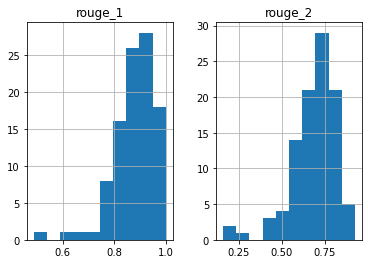

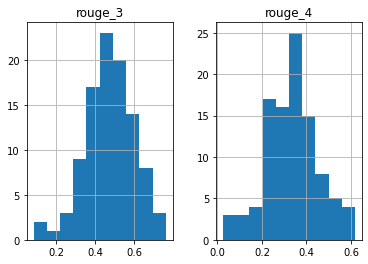

In [18]:
display(dataset[["rouge_1", "rouge_2"]].hist())
display(dataset[["rouge_3", "rouge_4"]].hist())

In [30]:
ind = dataset.rouge_1.argmax()
row = dataset.loc[ind]
print(row["rouge_1"])
print(row["citation_sentence"])
print()
for s in row["topk_cited_sentences"]: print(s)

1.0
They found that the improvement in OS was only marginally statistically significant in patients receiving TKIs therapy, which was similar to our conclusion [7, 8] .

However, a recent trial reported that chemotherapy was superior over erlotinib as second-line treatment for patients without EGFR mutations in exon 19 or 21 (14) .
Although a small benefit of EGFR-TKIs over placebo in the EGFRmut -subgroup has been demonstrated in three maintenance studies [SATURN (13) , INFORM (30) , and IFCT-GFPC 0502 (32, 44) ] (pooled HR = 0.81; 95% CI = 0.68 to 0.97; P = .02), it must be realized that this benefit is markedly and both clinically and statistically significantly greater in EGFRmut + subgroups (pooled HR = 0.15; 95% CI = 0.08 to 0.27; P < .001), and the test of interaction between EGFR mutation status and treatment is highly statistically significant (P < .001).
Clinicopathological and demographic characteristics of patients enrolled in these studies are summarized in Table 1 .
A sen

## 6. Convert to scr

In [19]:
# import time

# from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters

# import sent2vec
# from sklearn.metrics.pairwise import cosine_similarity

# # initialise sentence tokenizer
# # tokenizer should not split at abbrieviations
# punkt_params = PunktParameters()
# punkt_params.abbrev_types = set(["i.e", "e.g", "etc", "al", "fig", "figs", 
#                                  "ref", "refs", "p", "c", "s"]) 
# tokenizer = PunktSentenceTokenizer(punkt_params)

# # initialise sentence embedding model 
# model = sent2vec.Sent2vecModel()
# model.load_model("../sent2vec/wiki_unigrams.bin")
    

# time_taken = []
# all_topk_scores = []
# all_topk_cited_sentences = []
# all_rouge = {i:[] for i in range(5)}
# with open("../data/citation_generation/unique_dataset.jsonl", "r") as f:
#     for line in tqdm(f):
#         start = time.time()
#         row = json.loads(line)
        
#         # extract data from row
#         citation_sentence = row["citation_sentence"]
#         manuscript_result_text = row["manuscript_result_text"]
#         cited_text = row["cited_text"]
        
#         # tokenize manuscript_result_text, cited_text into sentences
#         query_sentences = tokenizer.tokenize(manuscript_result_text)
#         cited_sentences = tokenizer.tokenize(cited_text)
        
#         # compute sentence embeddings
#         query_embeddings = model.embed_sentences(query_sentences)
#         cited_embeddings = model.embed_sentences(cited_sentences)
        
#         # compute similarity matrix
#         similarity = cosine_similarity(query_embeddings, cited_embeddings)
        
#         # get indices of highest similarity scores 
#         indices = np.argpartition(similarity, kth=-k, axis=None)[-k:]

#         # get indices in decreasing order wrt scores and corresponding scores 
#         indices = np.flip(indices[np.argsort(similarity.flatten()[indices])])
#         topk_scores = similarity.flatten()[indices]
#         all_topk_scores.append(topk_scores)
        
#         # get corresponding cited_sentences 
#         indices %= similarity.shape[1]
#         topk_cited_sentences = [cited_sentences[i] for i in indices]
#         all_topk_cited_sentences.append(topk_cited_sentences)

#         # record rouge scores
#         for i in range(1,5):
#             all_rouge[i].append(rouge_n(citation_sentence, " ".join(topk_cited_sentences), n=i))
        
#         # record time taken for this row
#         time_taken.append(time.time() - start)
#         break